## Fine-tune Llama 2 for Sentiment Analysis

For this hands-on tutorial on fine-tuning a Llama 2 model, I am going to deal with a sentiment analysis on financial and economic information. Sentiment analysis on financial and economic information is highly relevant for businesses for several key reasons, ranging from market insights (gain valuable insights into market trends, investor confidence, and consumer behavior) to risk management (identifying potential reputational risks) to investment decisions (gauging the sentiment of stakeholders, investors, and the general public businesses can assess the potential success of various investment opportunities).

Before the technicalities of fine-tuning a large language model like Llama 2, we have to find the correct dataset to demonstrate the potentialities of fine-tuning.

Particularly within the realm of finance and economic texts, annotated datasets are notably rare, with many being exclusively reserved for proprietary purposes. To address the issue of insufficient training data, scholars from the Aalto University School
of Business introduced in 2014 a set of approximately 5000 sentences. This collection aimed to establish human-annotated benchmarks, serving as a standard for evaluating alternative modeling techniques. The involved annotators (16 people with
adequate background knowledge on financial markets) were instructed to assess the sentences solely from the perspective of an investor, evaluating whether the news potentially holds a positive, negative, or neutral impact on the stock price.

The FinancialPhraseBank dataset is a comprehensive collection that captures the sentiments of financial news headlines from the viewpoint of a retail investor. Comprising two key columns, namely "Sentiment" and "News Headline," the dataset effectively classifies sentiments as either negative, neutral, or positive. This structured dataset serves as a valuable resource for analyzing and understanding the complex dynamics of sentiment in the domain of financial news. It has been used in various studies and research initiatives, since its inception in the work by Malo, P., Sinha, A., Korhonen, P., Wallenius, J., and Takala, P.  "Good debt or bad debt: Detecting semantic orientations in economic texts.", published in the Journal of the Association for Information Science and Technology in 2014.

As a first step, we install the specific libraries necessary to make this example work.

* accelerate is a distributed training library for PyTorch by HuggingFace. It allows you to train your models on multiple GPUs or CPUs in parallel (distributed configurations), which can significantly speed up training in presence of multiple GPUs (we won't use it in our example).
* peft is a Python library by HuggingFace for efficient adaptation of pre-trained language models (PLMs) to various downstream applications without fine-tuning all the model's parameters. PEFT methods only fine-tune a small number of (extra) model parameters, thereby greatly decreasing the computational and storage costs.
* bitsandbytes by Tim Dettmers, is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and quantization functions. It allows to run models stored in 4-bit precision: while 4-bit bitsandbytes stores weights in 4-bits, the computation still happens in 16 or 32-bit and here any combination can be chosen (float16, bfloat16, float32, and so on).
* transformers is a Python library for natural language processing (NLP). It provides a number of pre-trained models for NLP tasks such as text classification, question answering, and machine translation.
* trl is a full stack library by HuggingFace providing a set of tools to train transformer language models with Reinforcement Learning, from the Supervised Fine-tuning step (SFT), Reward Modeling step (RM) to the Proximal Policy Optimization (PPO) step.

## Installations and imports

In [1]:
!pip install -q -U "torch==2.1.2" tensorboard

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
!pip install -q -U "transformers==4.36.2" "datasets==2.16.1" "accelerate==0.26.1" "bitsandbytes==0.42.0"

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


The code imports the os module and sets two environment variables:
* CUDA_VISIBLE_DEVICES: This environment variable tells PyTorch which GPUs to use. In this case, the code is setting the environment variable to 0, which means that PyTorch will use the first GPU.
* TOKENIZERS_PARALLELISM: This environment variable tells the Hugging Face Transformers library whether to parallelize the tokenization process. In this case, the code is setting the environment variable to false, which means that the tokenization process will not be parallelized.

In [3]:
!pip install -q -U git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e
!pip install -q -U git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

The code import warnings; warnings.filterwarnings("ignore") imports the warnings module and sets the warning filter to ignore. This means that all warnings will be suppressed and will not be displayed. Actually during training there are many warnings that do not prevent the fine-tuning but can be distracting and make you wonder if you are doing the correct things.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In the following cell there are all the other imports for running the notebook

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

2024-09-25 07:26:04.865344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 07:26:05.535915: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
print(f"pytorch version {torch.__version__}")

pytorch version 2.1.2+cu121


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


## Preparing the data and the core evaluation functions

The code in the next cell performs the following steps:

1. Reads the input dataset from the all-data.csv file, which is a comma-separated value (CSV) file with two columns: sentiment and text.
2. Splits the dataset into training and test sets, with 300 samples in each set. The split is stratified by sentiment, so that each set contains a representative sample of positive, neutral, and negative sentiments.
3. Shuffles the train data in a replicable order (random_state=10)
4. Transforms the texts contained in the train and test data into prompts to be used by Llama: the train prompts contains the expected answer we want to fine-tune the model with
5. The residual examples not in train or test, for reporting purposes during training (but it won't be used for early stopping), is treated as evaluation data, which is sampled with repetition in order to have a 50/50/50 sample (negative instances are very few, hence they should be repeated)
5. The train and eval data are wrapped by the class from Hugging Face (https://huggingface.co/docs/datasets/index)

This prepares in a single cell train_data, eval_data and test_data datasets to be used in our fine tuning.

In [9]:
filename = "../../data/all-data.csv"

df = pd.read_csv(filename, 
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment], 
                                    train_size=300,
                                    test_size=300, 
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), 
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), 
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

Next we create a function to evaluate the results from our fine-tuned sentiment model. The function performs the following steps:

1. Maps the sentiment labels to a numerical representation, where 2 represents positive, 1 represents neutral, and 0 represents negative.
2. Calculates the accuracy of the model on the test data.
3. Generates an accuracy report for each sentiment label.
4. Generates a classification report for the model.
5. Generates a confusion matrix for the model.

In [20]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    
    class_report = classification_report(y_true=y_true, y_pred=y_pred, output_dict= True)
    class_report_df = pd.DataFrame(class_report).transpose()
    print('\nClassification Report:')
    # Plot classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False)
    plt.title('Classification Report')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#     print(conf_matrix)

## Testing the model without fine-tuning

Next we need to take care of the model, which is a 7b-hf (7 billion parameters, no RLHF, in the HuggingFace compatible format), loading from Kaggle models and quantization.

Model loading and quantization:

* First the code loads the Llama-2 language model from the Hugging Face Hub.
* Then the code gets the float16 data type from the torch library. This is the data type that will be used for the computations.
* Next, it creates a BitsAndBytesConfig object with the following settings:
    1. load_in_4bit: Load the model weights in 4-bit format.
    2. bnb_4bit_quant_type: Use the "nf4" quantization type. 4-bit NormalFloat (NF4), is a new data type that is information theoretically optimal for normally distributed weights.
    3. bnb_4bit_compute_dtype: Use the float16 data type for computations.
    4. bnb_4bit_use_double_quant: Do not use double quantization (reduces the average memory footprint by quantizing also the quantization constants and saves an additional 0.4 bits per parameter.).
* Then the code creates a AutoModelForCausalLM object from the pre-trained Llama-2 language model, using the BitsAndBytesConfig object for quantization.
* After that, the code disables caching for the model.
* Finally the code sets the pre-training token probability to 1.

Tokenizer loading:

* First, the code loads the tokenizer for the Llama-2 language model.
* Then it sets the padding token to be the end-of-sequence (EOS) token.
* Finally, the code sets the padding side to be "right", which means that the input sequences will be padded on the right side. This is crucial for correct padding direction (this is the way with Llama 2).

In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [14]:
# model_name = "../input/llama-2/pytorch/7b-hf/1"
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "NousResearch/Llama-2-7b-chat-hf"
compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path = model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In the next cell, we set a function for predicting the sentiment of a news headline using the Llama-2 language model. The function takes three arguments:

test: A Pandas DataFrame containing the news headlines to be predicted.
model: The pre-trained Llama-2 language model.
tokenizer: The tokenizer for the Llama-2 language model.

The function works as follows:

1. For each news headline in the test DataFrame:
    * Create a prompt for the language model, which asks it to analyze the sentiment of the news headline and return the corresponding sentiment label.
    * Use the pipeline() function from the Hugging Face Transformers library to generate text from the language model, using the prompt.
    * Extract the predicted sentiment label from the generated text.
    * Append the predicted sentiment label to the y_pred list.
2. Return the y_pred list.

The pipeline() function from the Hugging Face Transformers library is used to generate text from the language model. The task argument specifies that the task is text generation. The model and tokenizer arguments specify the pre-trained Llama-2 language model and the tokenizer for the language model. The max_new_tokens argument specifies the maximum number of new tokens to generate. The temperature argument controls the randomness of the generated text. A lower temperature will produce more predictable text, while a higher temperature will produce more creative and unexpected text.

The if statement checks if the generated text contains the word "positive". If it does, then the predicted sentiment label is "positive". Otherwise, the if statement checks if the generated text contains the word "negative". If it does, then the predicted sentiment label is "negative". Otherwise, the if statement checks if the generated text contains the word "neutral". If it does, then the predicted sentiment label is "neutral.

In [15]:
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens = 1, 
                        temperature = 0.001,
                       )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

At this point, we are ready to test the Llama 2 7b-hf model and see how it performs on our problem without any fine-tuning. This allows us to get insights on the model itself and establish a baseline.

In [16]:
y_pred = predict(test, model, tokenizer)

100%|█████████████████████████████████████████████████████████████████████████████████| 900/900 [05:54<00:00,  2.54it/s]


In the following cell, we evaluate the results. There is little to be said, it is performing really terribly because the 7b-hf model tends to just predict a neutral sentiment and seldom it detects positive or negative sentiment.

Accuracy: 0.723
Accuracy for label 0: 0.960
Accuracy for label 1: 0.370
Accuracy for label 2: 0.840

Classification Report:


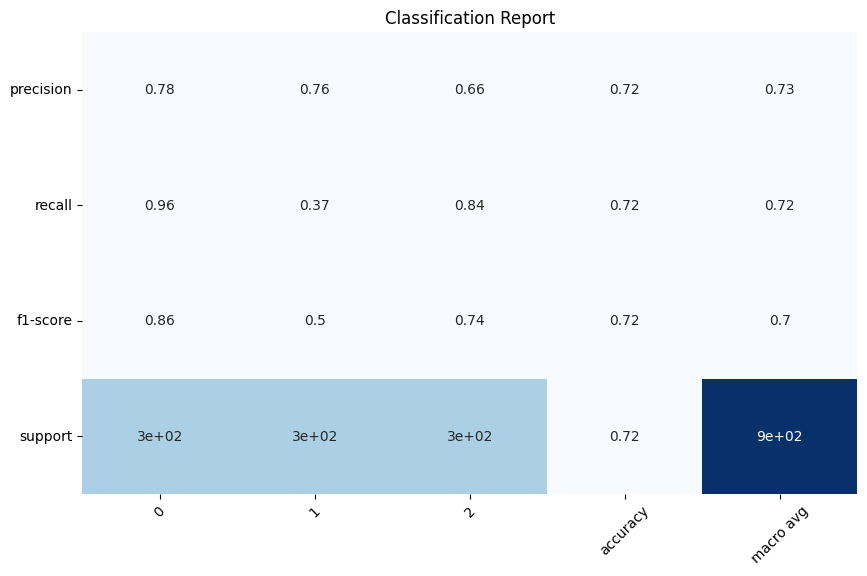


Confusion Matrix:


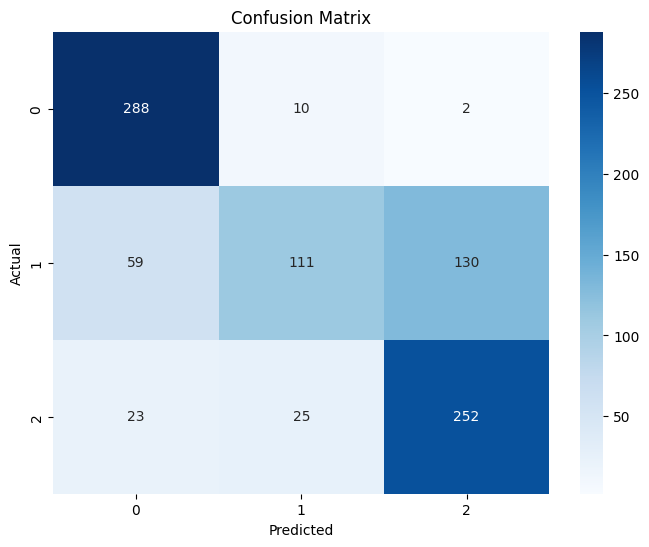

In [21]:
evaluate(y_true, y_pred)

## Fine-tuning

In the next cell we set everything ready for the fine-tuning. We configures and initializes a Simple Fine-tuning Trainer (SFTTrainer) for training a large language model using the Parameter-Efficient Fine-Tuning (PEFT) method, which should save time as it operates on a reduced number of parameters compared to the model's overall size. The PEFT method focuses on refining a limited set of (additional) model parameters, while keeping the majority of the pre-trained LLM parameters fixed. This significantly reduces both computational and storage expenses. Additionally, this strategy addresses the challenge of catastrophic forgetting, which often occurs during the complete fine-tuning of LLMs.

PEFTConfig:

The peft_config object specifies the parameters for PEFT. The following are some of the most important parameters:

* lora_alpha: The learning rate for the LoRA update matrices.
* lora_dropout: The dropout probability for the LoRA update matrices.
* r: The rank of the LoRA update matrices.
* bias: The type of bias to use. The possible values are none, additive, and learned.
* task_type: The type of task that the model is being trained for. The possible values are CAUSAL_LM and MASKED_LM.

TrainingArguments:

The training_arguments object specifies the parameters for training the model. The following are some of the most important parameters:

* output_dir: The directory where the training logs and checkpoints will be saved.
* num_train_epochs: The number of epochs to train the model for.
* per_device_train_batch_size: The number of samples in each batch on each device.
* gradient_accumulation_steps: The number of batches to accumulate gradients before updating the model parameters.
* optim: The optimizer to use for training the model.
* save_steps: The number of steps after which to save a checkpoint.
* logging_steps: The number of steps after which to log the training metrics.
* learning_rate: The learning rate for the optimizer.
* weight_decay: The weight decay parameter for the optimizer.
* fp16: Whether to use 16-bit floating-point precision.
* bf16: Whether to use BFloat16 precision.
* max_grad_norm: The maximum gradient norm.
* max_steps: The maximum number of steps to train the model for.
* warmup_ratio: The proportion of the training steps to use for warming up the learning rate.
* group_by_length: Whether to group the training samples by length.
* lr_scheduler_type: The type of learning rate scheduler to use.
* report_to: The tools to report the training metrics to.
* evaluation_strategy: The strategy for evaluating the model during training.

SFTTrainer:

The SFTTrainer is a custom trainer class from the TRL library. It is used to train large language models (also using the PEFT method).

The SFTTrainer object is initialized with the following arguments:

* model: The model to be trained.
* train_dataset: The training dataset.
* eval_dataset: The evaluation dataset.
* peft_config: The PEFT configuration.
* dataset_text_field: The name of the text field in the dataset.
* tokenizer: The tokenizer to use.
* args: The training arguments.
* packing: Whether to pack the training samples.
* max_seq_length: The maximum sequence length.

Once the SFTTrainer object is initialized, it can be used to train the model by calling the train() method

In [1]:
output_dir="trained_weigths"

peft_config = LoraConfig(
        lora_alpha=16, 
        lora_dropout=0.1,
        r=64,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=3,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="epoch"               # save checkpoint every epoch
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=1024,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

NameError: name 'LoraConfig' is not defined

The following code will train the model using the trainer.train() method and then save the trained model to the trained-model directory. Using The standard GPU P100 offered by Kaggle, the training should be quite fast.

In [ ]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Error out of memory at line 380 in file /mmfs1/gscratch/zlab/timdettmers/git/bitsandbytes/csrc/pythonInterface.c


The model and the tokenizer are saved to disk for later usage.

In [ ]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

Afterwards, loading the TensorBoard extension and start TensorBoard, pointing to the logs/runs directory, which is assumed to contain the training logs and checkpoints for your model, will allow you to understand how the models fits during the training.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/runs

## Saving model to disk for later usage

At this point, in order to demonstrate how to re-utilize the model, we reload it from the disk and merge it with the original LLama model.

In fact, when working with QLoRA, we exclusively train adapters instead of the entire model. So, when you save the model during training, you're only preserving the adapter weights, not the entire model. If you want to save the full model for easier use with Text Generation Inference, you can merge the adapter weights into the model weights using the merge_and_unload method. Then, you can save the model using the save_pretrained method. This will create a default model that's ready for inference tasks.

Before proceeding, we first remove the previous model and clean up the memory from various objects we won't use anymore.

In [ ]:
import gc

del [model, tokenizer, peft_config, trainer, train_data, eval_data, bnb_config, training_arguments]
del [df, X_train, X_eval]
del [TrainingArguments, SFTTrainer, LoraConfig, BitsAndBytesConfig]

In [ ]:
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
!nvidia-smi

# Merging the fine-tuned weights with original model

Then we can proceed to merging the weights and we will be using the merged model for our testing purposes.

In [ ]:
from peft import AutoPeftModelForCausalLM

finetuned_model = "./trained_weigths/"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf",)

model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,
     return_dict=False,
     low_cpu_mem_usage=True,
     device_map=device,
)

merged_model = model.merge_and_unload()
merged_model.save_pretrained("./merged_model",safe_serialization=True, max_shard_size="2GB")
tokenizer.save_pretrained("./merged_model")

## Testing

The following code will first predict the sentiment labels for the test set using the predict() function. Then, it will evaluate the model's performance on the test set using the evaluate() function. The result now should be impressive with an overall accuracy of over 0.8 and high accuracy, precision and recall for the single sentiment labels. The prediction of the neutral label can still be improved, yet it is impressive how much could be done with little data and some fine-tuning.

In [ ]:
y_pred = predict(test, merged_model, tokenizer)
evaluate(y_true, y_pred)

The following code will create a Pandas DataFrame called evaluation containing the text, true labels, and predicted labels from the test set. This is expectially useful for understanding the errors that the fine-tuned model makes, and gettting insights on how to improve the prompt.

In [ ]:
len(y_pred)

In [ ]:
print("Unique labels in y_true:", np.unique(y_true))
print("Unique labels in y_pred:", np.unique(y_pred))

In [ ]:
# Ensure the labels parameter matches the unique labels in y_true and y_pred
labels = np.unique(y_true)

# Generate classification report
class_report = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)
print('\nClassification Report:')
print(classification_report(y_true=y_true, y_pred=y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
print('\nConfusion Matrix:')
print(conf_matrix)


In [ ]:
# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plot classification report
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False)
plt.title('Classification Report')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
evaluation = pd.DataFrame({'text': X_test["text"], 
                           'y_true':y_true, 
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

The evaluation results are indeed good when compared to simpler benchmarks such as a CONV1D + bidirectional LSTM based model () such as: https://www.kaggle.com/code/lucamassaron/lstm-baseline-for-sentiment-analysis

Here are the results of the baseline model:

Accuracy: 0.623
Accuracy for label 0: 0.620
Accuracy for label 1: 0.590
Accuracy for label 2: 0.660

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.62      0.69       300
           1       0.61      0.59      0.60       300
           2       0.53      0.66      0.59       300

    accuracy                           0.62       900
   macro avg       0.64      0.62      0.63       900
weighted avg       0.64      0.62      0.63       900


Confusion Matrix:

[[186  39  75]\
 [ 23 177 100]\
 [ 27  75 198]]
 

With this testing, the fine-tuning of Llama 2 has reached its conclusion. Dont't forget to upvote if you find the notebook useful for your projects or work! 

# StockTwits


In [ ]:
from peft import AutoPeftModelForCausalLM

finetuned_model = "./trained_weigths/"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf",)

model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,
     return_dict=False,
     low_cpu_mem_usage=True,
     device_map=device,
)

merged_model = model.merge_and_unload()
merged_model.save_pretrained("./merged_model",safe_serialization=True, max_shard_size="2GB")
tokenizer.save_pretrained("./merged_model")

In [ ]:
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = merged_model.generate(**inputs)
    sentiment_score = process_outputs(outputs)  # Define your own logic to convert outputs to a sentiment score
    return sentiment_score

def process_outputs(outputs):
    # Example function to process model outputs into sentiment scores
    # This needs to be implemented based on how your model outputs sentiment
    return float(outputs.logits[0])
